In [1]:
import pandas as pd
from pandas import DataFrame as DF
from math import ceil
from time import time
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from filter_with_gmm import filter_with_gmm

In [2]:
# run transform.R before analysing the data.
df = read_csv("Levine_32dimtransform.csv")

In [3]:
markers = list(df)[4:36]

In [7]:
df[df[markers] < 0] = 0

In [19]:
def get_assignments(label,true='label', df=df):
    cluster_assignmetns = []
    labels = df[true].unique()
    for l in labels:
        cluster_assignmetns.append(
            list(
                df[df[label] == l]['event_number']
            ))
    return cluster_assignmetns

common = lambda i, j: len(np.intersect1d(i, j))
get_n = lambda list_: sum(len(i) for i in list_)

def purity(pred, true):
    """
    pred = predicted cluster assignments
    true = true cluster assignments (ground truth)
    get this from the data frame by:
    pred = get_assignments(label='predicted')
    true = get_assignments(label='true')
    purity(pred, true) -> output
    """
    n = get_n(true)
    P = sum(
            max([common(i, j) for i in true]) 
        for j in pred)
    return P / n

def purity2(true, pred):
    """
    A slightly different purity metric, should give
    higher values when the ground-truth cluster has been split 
    into smaller clusters by the algorithm.
    """
    return(
        sum([
            max([len(np.intersect1d(predi, truei)) / len(predi)
                for truei in true]) if len(predi) != 0 else 0
        for predi in pred]) / len(pred)
        )

In [26]:
def eval_NMF_sparsity(range_object):
    """
    Uses the global object df
    which should be a non-negative dataframe
    """
    nmfs = []
    Ws = []
    preds = []
    purities = []; purities2 = []
    true = get_assignments('label')
    for i in range_object:
        __nmf = NMF(n_components=15, init= "nndsvd", alpha=i, l1_ratio=1)
        __W = __nmf.fit_transform(df[markers].values)
        df['nmf{}'.format(i)] = __W.argmax(axis=1)
        __pred = get_assignments('nmf{}'.format(i))
        purities.append(purity(__pred, true))
        purities2.append(purity2(__pred, true))
        nmfs.append(__nmf)
        Ws.append(__W)
    return purities, purities2, nmfs, Ws


def get_dict(l1_values:range, purities:list)->dict:
    return (
        {i: p for i, p in zip(l1_values, purities)})

In [17]:
get_range = lambda: range(1, 6)

purity1, purity2, nmfs, Ws = eval_NMF_sparsity(get_range())
[get_dict(get_range(), p) for p in [purity1, purity2]]

[{1: 0.8515223066881671,
  2: 0.8463103739537741,
  3: 0.8391307686400983,
  4: 0.8295995546341088,
  5: 0.818379021730784},
 {1: 0.7291496015224234,
  2: 0.7352738162368648,
  3: 0.7454746709866781,
  4: 0.7563659630245226,
  5: 0.766308075918864}]

In [25]:
get_arange = lambda: np.arange(0.6, 1.4, 0.2)
purity1_lowl1, purity2_lowl1 = eval_NMF_sparsity(get_arange())
[get_dict(get_arange(), p) for p in [purity1_lowl1, purity2_lowl1]]

[{0.6: 0.8424038240036857,
  0.8: 0.8493722644551946,
  1.0: 0.8515990939107733,
  1.2000000000000002: 0.8515415034938186},
 {0.6: 0.7317598859506275,
  0.8: 0.73182463429534,
  1.0: 0.728950878243534,
  1.2000000000000002: 0.7296217228000759}]

In [28]:
get_arange = lambda: np.arange(1.2, 2, 0.2)
purity1_gt1lt2, purity2_gt1lt2, nmfs, Ws = eval_NMF_sparsity(get_arange())
[get_dict(get_arange(), p) for p in [purity1_gt1lt2, purity2_gt1lt2]]

[{1.2: 0.851771865161637,
  1.4: 0.8504760807801581,
  1.5999999999999999: 0.8494106580664977,
  1.7999999999999998: 0.8478845120172004},
 {1.2: 0.7295918525408737,
  1.4: 0.7303602259789338,
  1.5999999999999999: 0.7318337061537018,
  1.7999999999999998: 0.733338577328378}]

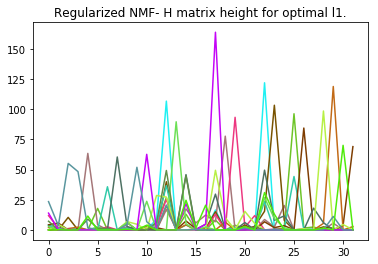

In [32]:
for comp in nmfs[0].components_:
    plt.plot(comp, c=np.random.rand(3))
plt.title('Regularized NMF- H matrix height for optimal l1.')
plt.show()

As can be seen form the above figure, the values in the H matrix are higher and more more alike. For example the highest value, at 17 is closer to the next ones. This means that markers are more evenly spread. 
Alpha around 1.0-1.1 is best.